In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
import exrex
import random
from sklearn.model_selection import KFold

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def generate_matching_strings(regex, num_samples, seq_length):
    # Generate strings that match the regular expression
    generated_strings = [exrex.getone(regex) for _ in range(num_samples)]
    generated_strings = [s[:seq_length] for s in generated_strings]
    return generated_strings

def generate_random_strings(alphabet, num_samples, seq_length):
    # Generate strings of specified length over the specified alphabet
    alphabet = ''.join(alphabet)
    res = [''.join(random.choices(alphabet, k=random.randint(0, seq_length))) for _ in range(num_samples)]
    return res

def generate_data(regex, alphabet, num_samples, seq_length, correct_proportion):
    num_correct = int(num_samples * correct_proportion)
    num_incorrect = num_samples - num_correct

    # Generate the correct and incorrect strings
    correct_data = generate_matching_strings(regex, num_correct, seq_length)
    incorrect_data = generate_random_strings(alphabet, num_incorrect, seq_length)

    # Combine them into one dataset with labels
    data = correct_data + incorrect_data
    labels = [1]*len(correct_data) + [0]*len(incorrect_data)

    # Shuffle data and labels in unison
    combined = list(zip(data, labels))
    random.shuffle(combined)
    data[:], labels[:] = zip(*combined)

    return data, labels

def sequences_to_one_hot(sequences, alphabet):
    alphabet_index = {char: i for i, char in enumerate(alphabet)}
    max_length = max(len(seq) for seq in sequences) if sequences else 1  # Ensure at least one time step

    one_hot_tensor = torch.zeros((len(sequences), max_length, len(alphabet)), dtype=torch.float32)
    for i, seq in enumerate(sequences):
        for j, char in enumerate(seq):
            one_hot_tensor[i, j, alphabet_index[char]] = 1

    sequence_lengths = torch.tensor([len(seq) if len(seq) > 0 else 1 for seq in sequences], dtype=torch.int64)
    return one_hot_tensor, sequence_lengths


class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        x_packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(x_packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output)
        output = torch.sigmoid(output[:, -1, :])
        return output

def train(model, criterion, optimizer, data, lengths, labels, epochs=10):
    model.train()
    loss_vector = []
    gradient_norms = []

    for epoch in range(epochs):
        epoch_gradients = []
        for i in range(len(data)):
            inputs = data[i].unsqueeze(0).to(device)
            seq_length = lengths[i].unsqueeze(0)  # Keep this tensor on CPU
            target = torch.tensor([labels[i]], dtype=torch.float).unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs, seq_length)
            loss = criterion(outputs, target)
            loss.backward()
            gradients = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters() if p.grad is not None))
            epoch_gradients.append(gradients.item())
            optimizer.step()

        loss_vector.append(loss.item())
        gradient_norms.append(epoch_gradients)

    return loss_vector, gradient_norms

def test(model, data, lengths, labels):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(data)):
            inputs = data[i].unsqueeze(0).to(device)
            seq_length = lengths[i].unsqueeze(0)  # Keep this tensor on CPU
            outputs = model(inputs, seq_length)
            predicted = outputs.round()
            total += 1
            correct += (predicted.item() == labels[i])

    accuracy = correct / total
    return accuracy


# Parameters
REGEX = '(00|11)*'
ALPHABET = ['0', '1']
PROPORTION = 0.5
NUM_SAMPLES = 1000
TRAIN_RATIO = 0.8
INPUT_SIZE = len(ALPHABET)  # Adjusted for one-hot encoding
HIDDEN_SIZE = 3
OUTPUT_SIZE = 1

# Sequence lengths
seq_lengths = [1, 10, 100, 1000, 10000]
#seq_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

# Store results
results = []

HIDDEN_SIZES = [2, 6, 10, 14, 18]
#HIDDEN_SIZES = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

for seq_length in seq_lengths:
    for hidden_size in HIDDEN_SIZES:
        print("\nTraining Segment for Sequence Length", seq_length, "and Hidden Size", hidden_size)
        print("=======================================")

        data, labels = generate_data(REGEX, ALPHABET, NUM_SAMPLES, seq_length, PROPORTION)
        data, sequence_lengths = sequences_to_one_hot(data, ALPHABET)

        # Split data into training and testing
        split_index = int(len(data) * TRAIN_RATIO)
        train_data, test_data = data[:split_index], data[split_index:]
        train_lengths, test_lengths = sequence_lengths[:split_index], sequence_lengths[split_index:]
        train_labels, test_labels = labels[:split_index], labels[split_index:]

        model = SimpleRNN(INPUT_SIZE, hidden_size, OUTPUT_SIZE).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        loss_vector, gradient_norms = train(model, criterion, optimizer, train_data, train_lengths, train_labels)
        accuracy = test(model, test_data, test_lengths, test_labels)

        avg_gradient_norms = [np.mean(epoch) for epoch in zip(*gradient_norms)]
        results.append({'Sequence Length': seq_length,
                        'Hidden Size': hidden_size,
                        'Loss Vector': loss_vector, 
                        'Accuracy': accuracy
                        #,'Average Gradient Norms': avg_gradient_norms
        })
        print(f'Sequence Length: {seq_length}, Hidden Size: {hidden_size}, Accuracy: {accuracy}')

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('rnn_experiment_results.csv', index=False)

Using device: cpu

Training Segment for Sequence Length 1 and Hidden Size 2
Sequence Length: 1, Hidden Size: 2, Accuracy: 0.685

Training Segment for Sequence Length 1 and Hidden Size 6
Sequence Length: 1, Hidden Size: 6, Accuracy: 0.63

Training Segment for Sequence Length 1 and Hidden Size 10
Sequence Length: 1, Hidden Size: 10, Accuracy: 0.745

Training Segment for Sequence Length 1 and Hidden Size 14
Sequence Length: 1, Hidden Size: 14, Accuracy: 0.55

Training Segment for Sequence Length 1 and Hidden Size 18
Sequence Length: 1, Hidden Size: 18, Accuracy: 0.73

Training Segment for Sequence Length 10 and Hidden Size 2
Sequence Length: 10, Hidden Size: 2, Accuracy: 0.805

Training Segment for Sequence Length 10 and Hidden Size 6


KeyboardInterrupt: 

In [ ]:
# Single state machine with alphabet {0}
regex = '0*'
alphabet = ['0']
data, labels = generate_data(regex, alphabet, 1000, 10, 0.5)

# Double state machine with alphabet {0,1} and transitions 00 and 11
regex = '(00|11)*'
alphabet = ['0', '1']
data, labels = generate_data(regex, alphabet, 1000, 10, 0.5)

# Triple state machine with alphabet {0,1,2} and transitions 00, 11, 22
regex = '(00|11|22)*'
alphabet = ['0', '1', '2']
data, labels = generate_data(regex, alphabet, 1000, 100, 0.5)

In [ ]:
for i in range(len(data)):
    print("data: " + str(data[i]))
    print("label: " + str(labels[i]))

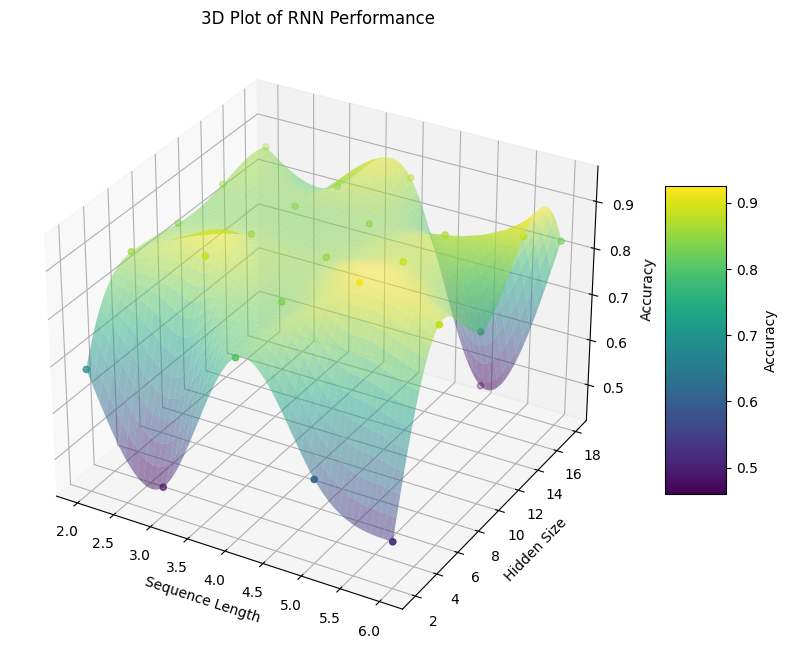

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

# Load the data
df = pd.read_csv('rnnSmallerSeq_comprhensive.csv')

# Extract the columns needed for the plot
seq_length = df['Sequence Length']
hidden_size = df['Hidden Size']
accuracy = df['Accuracy']

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(seq_length, hidden_size, accuracy, c=accuracy, cmap='viridis', marker='o')

# Create a manifold
# Generating a meshgrid for the manifold
x_lin = np.linspace(seq_length.min(), seq_length.max(), 100)
y_lin = np.linspace(hidden_size.min(), hidden_size.max(), 100)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)

# Interpolating data
z_grid = griddata((seq_length, hidden_size), accuracy, (x_grid, y_grid), method='cubic')

# Plotting the surface
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, cmap='viridis', edgecolor='none')

# Labels
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Hidden Size')
ax.set_zlabel('Accuracy')

# Color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Accuracy')

plt.title('3D Plot of RNN Performance')
plt.show()



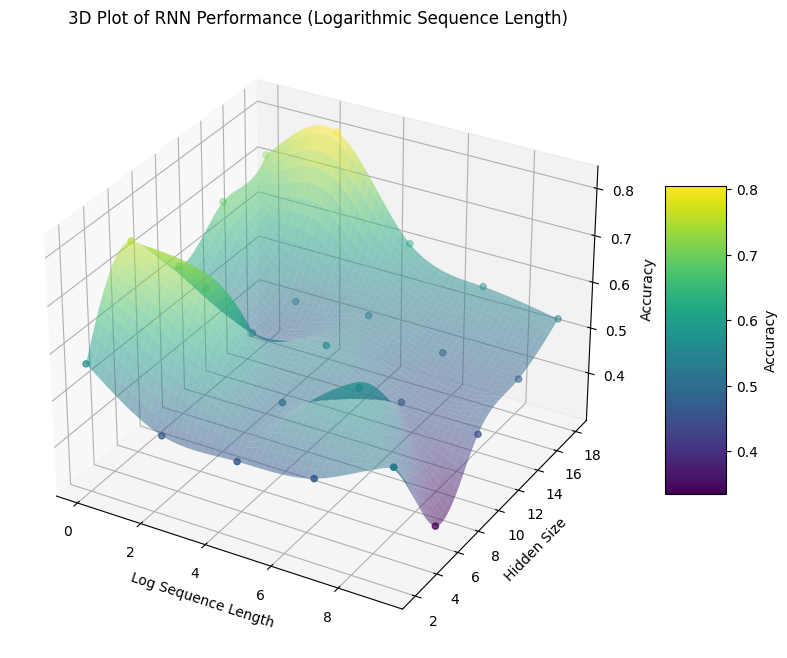

In [2]:
# Adjusting the plot to represent sequence length logarithmically

# Logarithmic transformation of sequence length for better visualization
log_seq_length = np.log(seq_length)

# Creating a new 3D scatter plot with logarithmic x-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(log_seq_length, hidden_size, accuracy, c=accuracy, cmap='viridis', marker='o')

# Create a manifold with logarithmic scale for sequence length
log_x_lin = np.linspace(log_seq_length.min(), log_seq_length.max(), 100)
y_lin = np.linspace(hidden_size.min(), hidden_size.max(), 100)
log_x_grid, y_grid = np.meshgrid(log_x_lin, y_lin)

# Interpolating data on the logarithmic scale
z_grid = griddata((log_seq_length, hidden_size), accuracy, (log_x_grid, y_grid), method='cubic')

# Plotting the surface
ax.plot_surface(log_x_grid, y_grid, z_grid, alpha=0.5, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_xlabel('Log Sequence Length')
ax.set_ylabel('Hidden Size')
ax.set_zlabel('Accuracy')
plt.title('3D Plot of RNN Performance (Logarithmic Sequence Length)')

# Color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Accuracy')

plt.show()



In [3]:
# Assuming the column names and structure, extract gradient norms
# This part of the code might need to be adjusted based on the actual structure of your CSV file
gradient_norms = df['Average Gradient Norms'].apply(eval)  # This converts string representations of lists back to lists

# Plotting
plt.figure(figsize=(10, 6))

for i, norms in enumerate(gradient_norms):
    plt.plot(norms, label=f'Experiment {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms Across Different Experiments')
plt.legend()
plt.show()


KeyError: 'Average Gradient Norms'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Assuming seq_length, hidden_size, and accuracy are already defined in your context
# ...

def interactive_plot(interpolation_method='cubic'):
    # Logarithmic transformation of sequence length for better visualization
    log_seq_length = np.log(seq_length)

    # Creating a new 3D scatter plot with logarithmic x-axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    scatter = ax.scatter(log_seq_length, hidden_size, accuracy, c=accuracy, cmap='viridis', marker='o')

    # Create a manifold with logarithmic scale for sequence length
    log_x_lin = np.linspace(log_seq_length.min(), log_seq_length.max(), 100)
    y_lin = np.linspace(hidden_size.min(), hidden_size.max(), 100)
    log_x_grid, y_grid = np.meshgrid(log_x_lin, y_lin)

    # Interpolating data on the logarithmic scale
    z_grid = griddata((log_seq_length, hidden_size), accuracy, (log_x_grid, y_grid), method=interpolation_method)

    # Plotting the surface
    ax.plot_surface(log_x_grid, y_grid, z_grid, alpha=0.5, cmap='viridis', edgecolor='none')

    # Labels and title
    ax.set_xlabel('Log Sequence Length')
    ax.set_ylabel('Hidden Size')
    ax.set_zlabel('Accuracy')
    plt.title('3D Plot of RNN Performance (Logarithmic Sequence Length)')

    # Color bar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Accuracy')

    plt.show()

# Using interact_manual to create a dropdown for selecting interpolation method
interact_manual(interactive_plot, interpolation_method=['linear', 'nearest', 'cubic'])


interactive(children=(Dropdown(description='interpolation_method', index=2, options=('linear', 'nearest', 'cub…

<function __main__.interactive_plot(interpolation_method='cubic')>

In [ ]:
!jupyter nbextension enable --py widgetsnbextension


In [4]:
import ipywidgets as widgets
widgets.IntSlider()


IntSlider(value=0)

In [ ]:
import pandas as pd

# Extracting the data from the log
data = """
1, 2, 0.57
1, 6, 0.75
1, 10, 0.62
1, 14, 0.685
1, 18, 0.715
10, 2, 0.465
10, 6, 0.695
10, 10, 0.52
10, 14, 0.51
10, 18, 0.805
100, 2, 0.46
100, 6, 0.5
100, 10, 0.54
100, 14, 0.525
100, 18, 0.605
1000, 2, 0.475
1000, 6, 0.58
1000, 10, 0.465
1000, 14, 0.49
1000, 18, 0.555
10000, 2, 0.55
10000, 6, 0.335
10000, 10, 0.445
10000, 14, 0.48
10000, 18, 0.53
"""

# Creating a DataFrame from the data
df = pd.DataFrame([x.split(", ") for x in data.strip().split('\n')], 
                  columns=['Sequence Length', 'Hidden Size', 'Accuracy'])
df['Sequence Length'] = df['Sequence Length'].astype(int)
df['Hidden Size'] = df['Hidden Size'].astype(int)
df['Accuracy'] = df['Accuracy'].astype(float)

# Saving the DataFrame to a CSV file
output_file_path = 'extracted_rnn_results.csv'
df.to_csv(output_file_path, index=False)

output_file_path

